In [1]:
import numpy as np
import random
import torch
from gpytorch.kernels import ScaleKernel, RBFKernel
from linear_operator.operators import KroneckerProductLinearOperator
from torch import Tensor
from torch.distributions import MultivariateNormal
from lvmogp_svi import LVMOGP_SVI
from gaussian_likelihood import GaussianLikelihood
from variational_elbo import VariationalELBO
from tqdm import trange
from torch.optim.lr_scheduler import StepLR
from util_functions import *
import gpytorch

In [2]:
# This section is same as 'no missing data' case.
idgp_w_n_C_total = 700 # totally 700 points for C
idgp_w_n_outputs = 20

In [3]:
expri_random_seed = 13

np.random.seed(expri_random_seed)
list_expri_random_seeds = np.random.randn(idgp_w_n_outputs)
print(list_expri_random_seeds)

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574]


In [4]:
# The following code generates all output data.
idgp_w_X_true, idgp_w_C_total, idgp_w_sample_total_data, kernel_parameters = tidily_sythetic_data_from_MOGP(n_C=idgp_w_n_C_total, n_X=idgp_w_n_outputs)

idgp_w_n_C_train = 20 # the number of training data points per output
idgp_w_n_C_test = idgp_w_n_C_total - idgp_w_n_C_train

# different from the previous case, C_train and C_test no longer a single set, but every output has different values.
idgp_w_ls_of_ls_train_C = []
idgp_w_ls_of_ls_test_C = []

idgp_w_sample_train_index, idgp_w_sample_test_index = [], []

for i in range(idgp_w_n_outputs):
    # iterate across different output functions
    random.seed(list_expri_random_seeds[i])
    train_index = random.sample(range(idgp_w_n_C_total), idgp_w_n_C_train)
    test_index = [index for index in range(idgp_w_n_C_total) if index not in train_index]
    idgp_w_ls_of_ls_train_C.append(train_index)
    idgp_w_ls_of_ls_test_C.append(test_index)
    
    idgp_w_sample_train_index = np.concatenate((idgp_w_sample_train_index, list(np.array(train_index) + idgp_w_n_C_total*i)))
    idgp_w_sample_test_index = np.concatenate((idgp_w_sample_test_index, list(np.array(test_index) + idgp_w_n_C_total*i)))

idgp_w_sample_train_data = idgp_w_sample_total_data[idgp_w_sample_train_index]
idgp_w_sample_test_data = idgp_w_sample_total_data[idgp_w_sample_test_index]

# data for all outouts ...
assert idgp_w_sample_train_data.shape[0] == idgp_w_n_C_train * idgp_w_n_outputs
assert idgp_w_sample_test_data.shape[0] == idgp_w_n_C_test * idgp_w_n_outputs
assert idgp_w_sample_total_data.shape[0] == idgp_w_n_C_total * idgp_w_n_outputs

In [5]:
list_idgp_function_index = [i for i in range(idgp_w_n_outputs)]
list_train_X, list_train_Y = [], [] 
list_test_X, list_test_Y = [], []
list_total_X, list_total_Y = [], [] 

for idgp_function_index in list_idgp_function_index:
    # start and end
    idgp_train_start = idgp_function_index * idgp_w_n_C_train
    idgp_train_end = idgp_train_start + idgp_w_n_C_train

    idgp_test_start = idgp_function_index * idgp_w_n_C_test
    idgp_test_end = idgp_test_start + idgp_w_n_C_test

    idgp_total_start = idgp_function_index * idgp_w_n_C_total
    idgp_total_end = idgp_total_start + idgp_w_n_C_total

    # training data
    train_X = idgp_w_C_total[idgp_w_ls_of_ls_train_C[idgp_function_index]]
    train_Y = idgp_w_sample_train_data[idgp_train_start:idgp_train_end]
    assert train_X.shape ==  train_Y.shape == torch.Size([idgp_w_n_C_train])
    list_train_X.append(train_X)
    list_train_Y.append(train_Y)

    # testing data
    test_X = idgp_w_C_total[idgp_w_ls_of_ls_test_C[idgp_function_index]]
    test_Y = idgp_w_sample_test_data[idgp_test_start:idgp_test_end]
    assert test_X.shape == test_Y.shape == torch.Size([idgp_w_n_C_test]) 
    list_test_X.append(test_X)
    list_test_Y.append(test_Y)

    # total data, of length idgp_w_n_C_total
    total_X = idgp_w_C_total
    total_Y = idgp_w_sample_total_data[idgp_total_start:idgp_total_end]
    assert total_X.shape == total_Y.shape == torch.Size([idgp_w_n_C_total])
    list_total_X.append(total_X)
    list_total_Y.append(total_Y)


In [6]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

# Model
class GPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(GPModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
# Hyperparameters
idgp_n_inducing_C = 15
learning_rate = 0.01

#### Train 20 gps one by one

In [8]:
from gaussian_likelihood import GaussianLikelihood
from variational_elbo import VariationalELBO

list_models = []
list_likelihoods = []
list_idgp_loss_list = []

for j in range(idgp_w_n_outputs):

    # current train_X and train_Y
    train_X = list_train_X[j]
    train_Y = list_train_Y[j]
    
    inducing_points = torch.rand(idgp_n_inducing_C).reshape(-1,1) * 20 - 10
    model = GPModel(inducing_points=inducing_points)
    likelihood = GaussianLikelihood()

    if torch.cuda.is_available():
        model = model.cuda()
        likelihood = likelihood.cuda()
    
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()},
    ], lr=learning_rate)

    wo_scheduler = StepLR(optimizer, step_size=50, gamma=0.95)  # 0.3, 50, 0.95; 

    # Our loss object. We're using the VariationalELBO
    mll = VariationalELBO(likelihood, model, num_data=train_Y.size(0))

    # have a look at parameters
    # for name, param in model.named_parameters():
    #    print(name, param.size())
        
    # start training!
    idgp_loss_list = []
    n_iterations = 2500 # 1500 # 10000
    iterator = trange(n_iterations, leave=True)
    idgp_model_max_grad_norm = 15
    idgp_likeli_max_grad_norm = 0.7

    for i in iterator:
        optimizer.zero_grad()
        output_pred = model(train_X)
        loss = -mll(output_pred, train_Y)
        idgp_loss_list.append(loss.item())
        iterator.set_description( 'Training '+ str(j) + 'th Model; '+ 'Loss: ' + str(float(np.round(loss.item(),3))) + ", iter no: " + str(i))
        loss.backward()

        # clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), idgp_model_max_grad_norm)
        torch.nn.utils.clip_grad_norm_(likelihood.parameters(), idgp_likeli_max_grad_norm)

        optimizer.step()
        wo_scheduler.step()

    # After traininhg, store all the models ... 
    list_models.append(model)
    list_likelihoods.append(likelihood)
    list_idgp_loss_list.append(idgp_loss_list)

Training 19th Model; Loss: 0.238, iter no: 2499: 100%|██████████| 2500/2500 [00:24<00:00, 102.18it/s]


#### Get 20 gp testing results one by one

In [9]:
list_idgp_train_output_dist = []
list_idgp_test_output_dist = []
list_idgp_total_output_dist = []

train_error_square_sum = 0
test_error_square_sum = 0

train_error_length = 0
test_error_length = 0

for j in range(idgp_w_n_outputs):
    curr_model = list_models[j]
    curr_likelihood = list_likelihoods[j]

    curr_train_X = list_train_X[j]
    curr_train_Y = list_train_Y[j]

    curr_test_X = list_test_X[j]
    curr_test_Y = list_test_Y[j]

    curr_total_X = list_total_X[j]
    curr_total_Y = list_total_Y[j]

    idgp_train_output_dist = curr_likelihood(curr_model(curr_train_X))
    idgp_test_output_dist  = curr_likelihood(curr_model(curr_test_X))
    idgp_total_output_dist = curr_likelihood(curr_model(curr_total_X))

    train_error_square_sum += (idgp_train_output_dist.loc.detach() - curr_train_Y).square().sum()
    print(str(j) + 'th Model Train RMSE: ', (idgp_train_output_dist.loc.detach() - curr_train_Y).square().mean().sqrt())
    test_error_square_sum += (idgp_test_output_dist.loc.detach() - curr_test_Y).square().sum()
    print(str(j) + 'th Model Test RMSE: ', (idgp_test_output_dist.loc.detach() - curr_test_Y).square().mean().sqrt())

    train_error_length += idgp_train_output_dist.loc.detach().shape[0]
    test_error_length += idgp_test_output_dist.loc.detach().shape[0]    

    list_idgp_train_output_dist.append(idgp_train_output_dist)
    list_idgp_test_output_dist.append(idgp_test_output_dist)
    list_idgp_total_output_dist.append(idgp_total_output_dist)


print('Global Train RMSE', (train_error_square_sum / train_error_length).sqrt())
print('Global Test RMSE', (test_error_square_sum / test_error_length).sqrt())


0th Model Train RMSE:  tensor(0.2406)
0th Model Test RMSE:  tensor(0.3535)
1th Model Train RMSE:  tensor(0.1797)
1th Model Test RMSE:  tensor(0.3464)
2th Model Train RMSE:  tensor(0.3123)
2th Model Test RMSE:  tensor(0.4416)
3th Model Train RMSE:  tensor(0.3251)
3th Model Test RMSE:  tensor(0.4148)
4th Model Train RMSE:  tensor(0.4105)
4th Model Test RMSE:  tensor(0.4514)
5th Model Train RMSE:  tensor(0.3059)
5th Model Test RMSE:  tensor(0.5528)
6th Model Train RMSE:  tensor(0.3683)
6th Model Test RMSE:  tensor(0.4443)
7th Model Train RMSE:  tensor(0.4078)
7th Model Test RMSE:  tensor(0.5940)
8th Model Train RMSE:  tensor(0.2448)
8th Model Test RMSE:  tensor(0.3748)
9th Model Train RMSE:  tensor(0.3154)
9th Model Test RMSE:  tensor(0.3594)
10th Model Train RMSE:  tensor(0.2345)
10th Model Test RMSE:  tensor(0.4722)
11th Model Train RMSE:  tensor(0.2673)
11th Model Test RMSE:  tensor(0.4091)
12th Model Train RMSE:  tensor(0.3936)
12th Model Test RMSE:  tensor(0.4179)
13th Model Train RM

#### select one output, and plot

In [18]:
selected_output_index = 19

selected_model = list_models[selected_output_index]
selected_train_X = list_train_X[selected_output_index]
selected_train_Y = list_train_Y[selected_output_index]
selected_test_X = list_test_X[selected_output_index]
selected_test_Y = list_test_Y[selected_output_index]
selected_gp_X = list_total_X[selected_output_index]
selected_gp_pred_mean = list_idgp_total_output_dist[selected_output_index].loc.detach()
selected_gp_pred_std = list_idgp_total_output_dist[selected_output_index].stddev.detach()

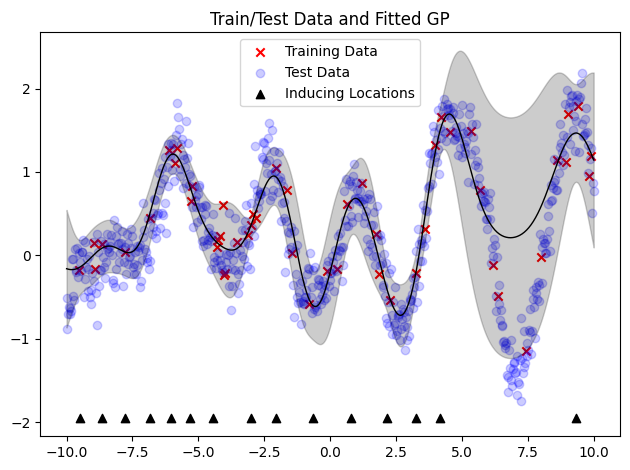

In [19]:
plot_traindata_testdata_fittedgp(train_X=selected_train_X, train_Y=selected_train_Y, test_X=selected_test_X, test_Y=selected_test_Y, gp_X=selected_gp_X, gp_pred_mean=selected_gp_pred_mean, gp_pred_std=selected_gp_pred_std, inducing_points_X=selected_model.variational_strategy.inducing_points.detach(), n_inducing_C=idgp_n_inducing_C) # NOTE: input is C not X